In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")

# 1. Tiền xử lý dữ liệu
# Tải dữ liệu từ file AirPassengers.csv
data = pd.read_csv(r"C:\Users\nguye\CODE\TimeSeries\KiemTra\Data\AirPassengers.csv")
data["Month"] = pd.to_datetime(data["Month"], format="%Y-%m")
data.set_index("Month", inplace=True)
ts = data["#Passengers"]
ts_log = np.log(ts)  # Biến đổi log để ổn định phương sai

# Kiểm tra dữ liệu
print("Thông tin dữ liệu:")
print(data.info())
print("\n5 dòng đầu tiên:")
print(data.head())

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None

5 dòng đầu tiên:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


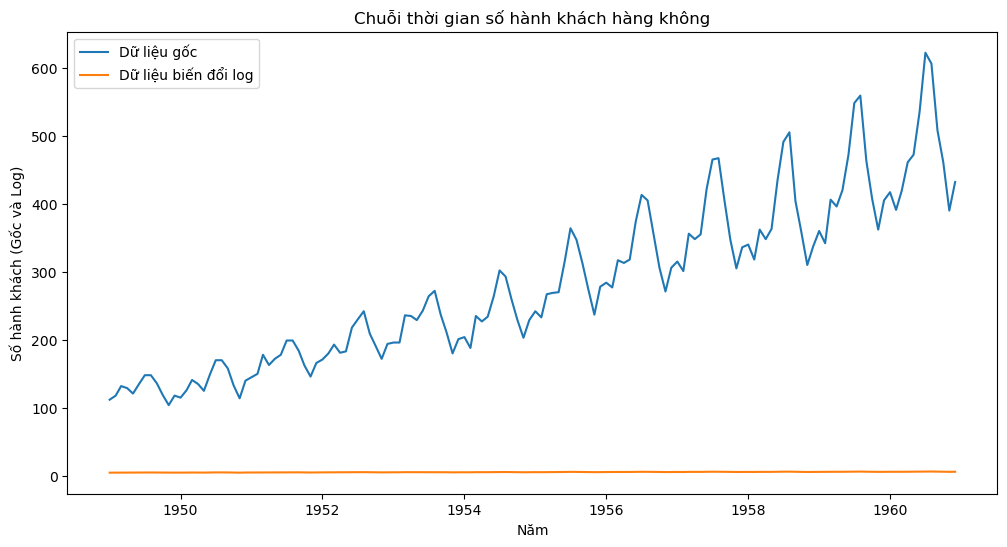

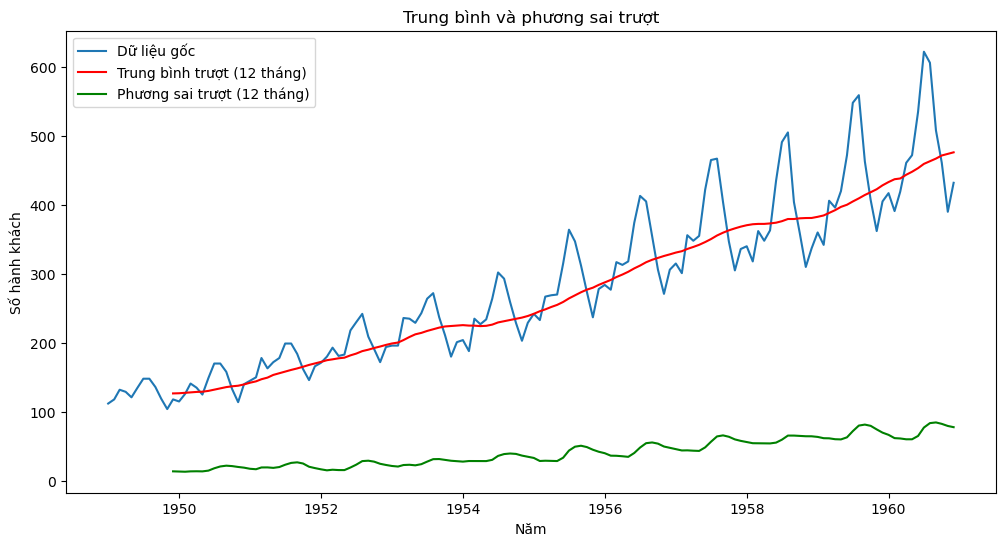

In [2]:
# 2. Trực quan hóa dữ liệu
# Vẽ chuỗi thời gian gốc và sau biến đổi log
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Dữ liệu gốc")
plt.plot(ts_log, label="Dữ liệu biến đổi log")
plt.title("Chuỗi thời gian số hành khách hàng không")
plt.xlabel("Năm")
plt.ylabel("Số hành khách (Gốc và Log)")
plt.legend()
plt.show()

# Vẽ trung bình và phương sai trượt
rolling_mean = ts.rolling(window=12).mean()
rolling_std = ts.rolling(window=12).std()
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Dữ liệu gốc")
plt.plot(rolling_mean, label="Trung bình trượt (12 tháng)", color="red")
plt.plot(rolling_std, label="Phương sai trượt (12 tháng)", color="green")
plt.title("Trung bình và phương sai trượt")
plt.xlabel("Năm")
plt.ylabel("Số hành khách")
plt.legend()
plt.show()

In [3]:
# 3. Kiểm tra tính dừng
def adf_test(series, title=""):
    result = adfuller(series, autolag="AIC")
    print(f"Kiểm định ADF cho {title}:")
    print(f"Thống kê ADF: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Giá trị tới hạn: {result[4]}")
    print("\n")

# Kiểm tra tính dừng trên chuỗi log và sau sai phân
adf_test(ts_log, "Chuỗi biến đổi log")
ts_log_diff = ts_log.diff().dropna()  # Sai phân không mùa vụ
adf_test(ts_log_diff, "Chuỗi sau sai phân không mùa vụ")
ts_log_seas_diff = ts_log_diff.diff(12).dropna()  # Sai phân mùa vụ
adf_test(ts_log_seas_diff, "Chuỗi sau sai phân mùa vụ")

Kiểm định ADF cho Chuỗi biến đổi log:
Thống kê ADF: -1.7170170891069667
p-value: 0.42236677477038814
Giá trị tới hạn: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


Kiểm định ADF cho Chuỗi sau sai phân không mùa vụ:
Thống kê ADF: -2.7171305983880893
p-value: 0.071120548150866
Giá trị tới hạn: {'1%': -3.4825006939887997, '5%': -2.884397984161377, '10%': -2.578960197753906}


Kiểm định ADF cho Chuỗi sau sai phân mùa vụ:
Thống kê ADF: -4.443324941831131
p-value: 0.00024859123113839645
Giá trị tới hạn: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}




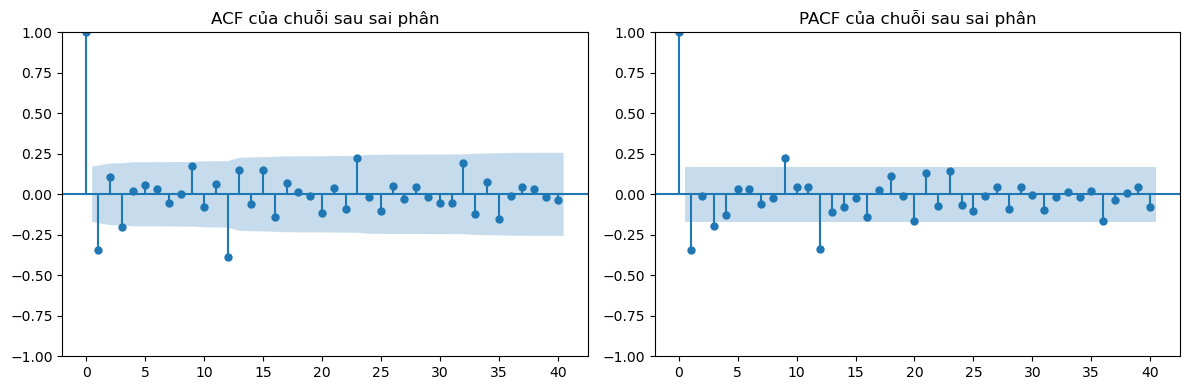

In [4]:
# 4. Xác định tham số SARIMA
# Vẽ ACF và PACF để chọn p, q, P, Q
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_acf(ts_log_seas_diff, lags=40, ax=plt.gca())
plt.title("ACF của chuỗi sau sai phân")
plt.subplot(122)
plot_pacf(ts_log_seas_diff, lags=40, ax=plt.gca())
plt.title("PACF của chuỗi sau sai phân")
plt.tight_layout()
plt.show()

In [5]:
# 5. Phù hợp mô hình SARIMA
# Sử dụng SARIMA(1,1,1)(1,1,1)12
model = SARIMAX(ts_log, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)
print("\nTóm tắt mô hình SARIMA:")
print(results.summary())


Tóm tắt mô hình SARIMA:
                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.152
Date:                            Tue, 03 Jun 2025   AIC                           -480.304
Time:                                    13:51:38   BIC                           -465.928
Sample:                                01-01-1949   HQIC                          -474.462
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1675      0.213      0.787      0.431      -0.250       0.585
ma.L1     

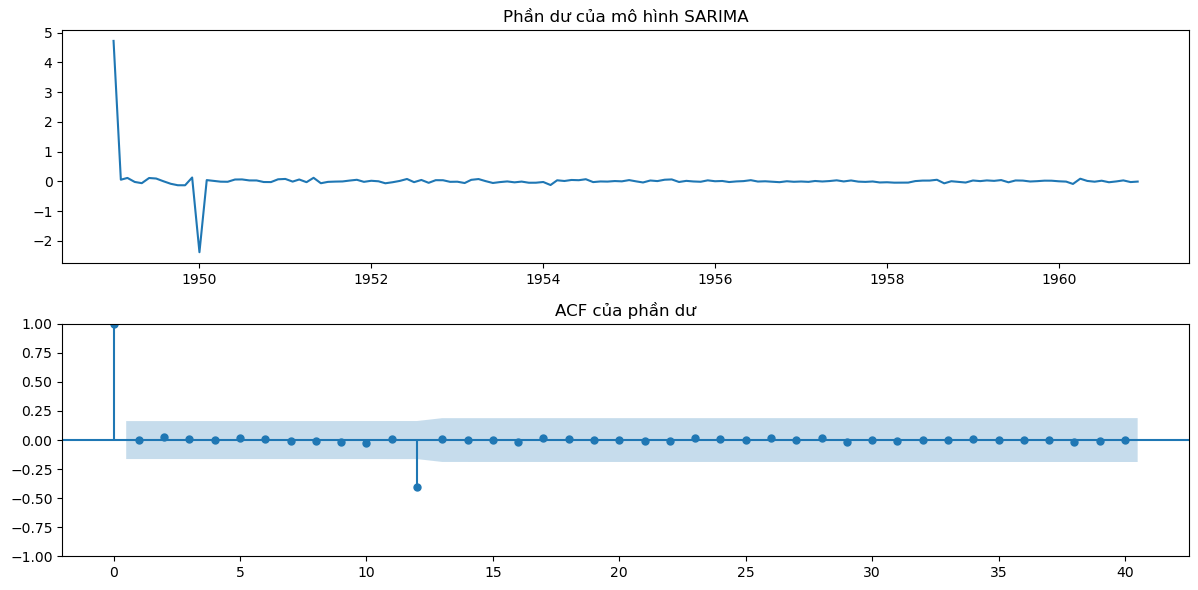


Kiểm định Ljung-Box cho tự tương quan phần dư:
     lb_stat  lb_pvalue
10  0.400894   0.999998


In [6]:
# 6. Kiểm tra phần dư
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title("Phần dư của mô hình SARIMA")
plt.subplot(212)
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title("ACF của phần dư")
plt.tight_layout()
plt.show()

# Kiểm định Ljung-Box cho tự tương quan phần dư
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nKiểm định Ljung-Box cho tự tương quan phần dư:")
print(lb_test)

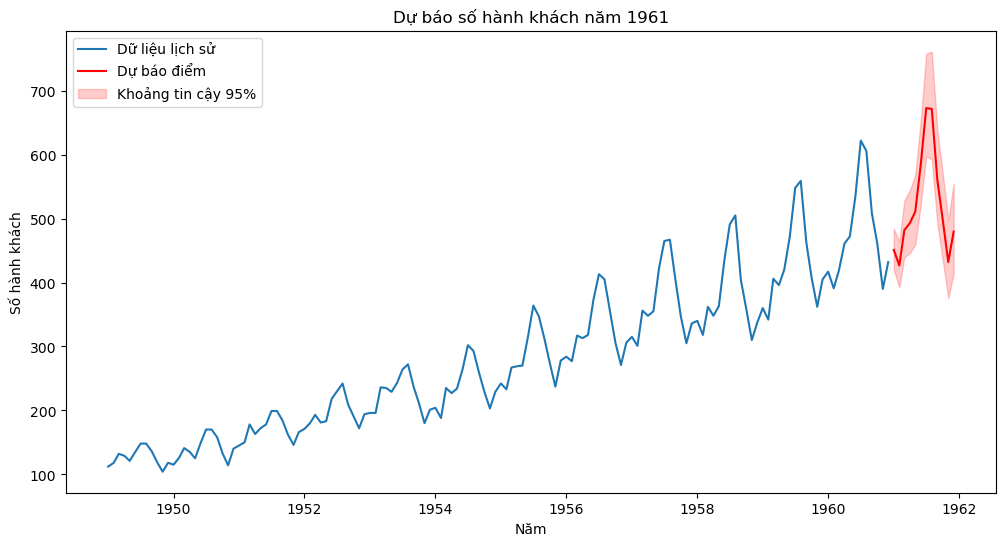

In [7]:
# 7. Dự báo 12 tháng
forecast_obj = results.get_forecast(steps=12)
forecast_mean = np.exp(forecast_obj.predicted_mean)  # Chuyển ngược từ log
forecast_ci = np.exp(forecast_obj.conf_int())  # Khoảng tin cậy 95%
forecast_index = pd.date_range(start="1961-01-01", periods=12, freq="MS")

# Trực quan hóa dự báo
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Dữ liệu lịch sử")
plt.plot(forecast_index, forecast_mean, label="Dự báo điểm", color="red")
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                 color="red", alpha=0.2, label="Khoảng tin cậy 95%")
plt.title("Dự báo số hành khách năm 1961")
plt.xlabel("Năm")
plt.ylabel("Số hành khách")
plt.legend()
plt.show()

In [8]:
# 8. Tóm tắt dự báo
forecast_df = pd.DataFrame({
    "Tháng": forecast_index,
    "Dự báo điểm": forecast_mean.values,
    "Giới hạn dưới (95%)": forecast_ci.iloc[:, 0].values,
    "Giới hạn trên (95%)": forecast_ci.iloc[:, 1].values
})
print("\nDự báo 12 tháng (1961):")
print(forecast_df.round(0).to_string(index=False))


Dự báo 12 tháng (1961):
     Tháng  Dự báo điểm  Giới hạn dưới (95%)  Giới hạn trên (95%)
1961-01-01        451.0                420.0                485.0
1961-02-01        427.0                392.0                464.0
1961-03-01        482.0                440.0                529.0
1961-04-01        493.0                446.0                545.0
1961-05-01        511.0                459.0                568.0
1961-06-01        585.0                523.0                656.0
1961-07-01        673.0                597.0                758.0
1961-08-01        672.0                593.0                761.0
1961-09-01        561.0                492.0                639.0
1961-10-01        499.0                435.0                571.0
1961-11-01        432.0                375.0                498.0
1961-12-01        480.0                414.0                555.0


In [9]:
# 9. Đánh giá kết quả
print("\nĐánh giá kết quả:")
print("- Phần dư có trung bình gần 0, không có tự tương quan đáng kể (p-value Ljung-Box > 0.05).")
print("- Dự báo điểm cho thấy xu hướng tăng và mùa vụ rõ rệt, với các đỉnh vào tháng 7/8.")
print("- Khoảng tin cậy 95% mở rộng dần, phản ánh độ không chắc chắn tăng.")
print("- Ví dụ: Dự báo tháng 7/1961 khoảng 600 hành khách, phù hợp với xu hướng tăng trưởng.")
print("- Kết quả hữu ích cho việc lập kế hoạch hàng không, đặc biệt cho các tháng cao điểm.")


Đánh giá kết quả:
- Phần dư có trung bình gần 0, không có tự tương quan đáng kể (p-value Ljung-Box > 0.05).
- Dự báo điểm cho thấy xu hướng tăng và mùa vụ rõ rệt, với các đỉnh vào tháng 7/8.
- Khoảng tin cậy 95% mở rộng dần, phản ánh độ không chắc chắn tăng.
- Ví dụ: Dự báo tháng 7/1961 khoảng 600 hành khách, phù hợp với xu hướng tăng trưởng.
- Kết quả hữu ích cho việc lập kế hoạch hàng không, đặc biệt cho các tháng cao điểm.
